In this section we try to use ARIMA model for time-series prediction

# 1. Installing required libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import warnings
warnings.filterwarnings("ignore")

# 2. Loading data and exploring data

In [50]:
data = pd.read_csv('Data_files/CSV/part-00000-4f161bf8-72b5-4963-84c9-7d9d786286f7-c000.csv', 
                   index_col = [0], parse_dates=[0], 
                   names = ['Date','Population', 'Consumption', 'Persevelance', 'AveragePrice'])
data.sort_index(inplace=True) 

Calculate Income based on columns above. All data will be displayed in billiards

In [51]:
data['Income'] = data['Population'].astype(float) * data['Consumption'].astype(float) *\
data['Persevelance'].astype(float) * data['AveragePrice'].astype(float)/20*365/10**9

In [52]:
data.head()

,Population,Consumption,Persevelance,AveragePrice,Income
Date,,,,,
2008-01-01,90910000,21.2,26.4,1.07,993.569136
2009-01-01,92438000,21.5,27.0,1.12,1096.815694
2010-01-01,93966000,21.5,27.6,1.17,1190.603110
2011-01-01,95595000,21.4,27.0,1.20,1209.641923
2012-01-01,97224000,21.4,26.5,1.23,1237.659308


In [53]:
# For ARIMA we use only Income column
ts = data['Income']
ts.shape

(11,)

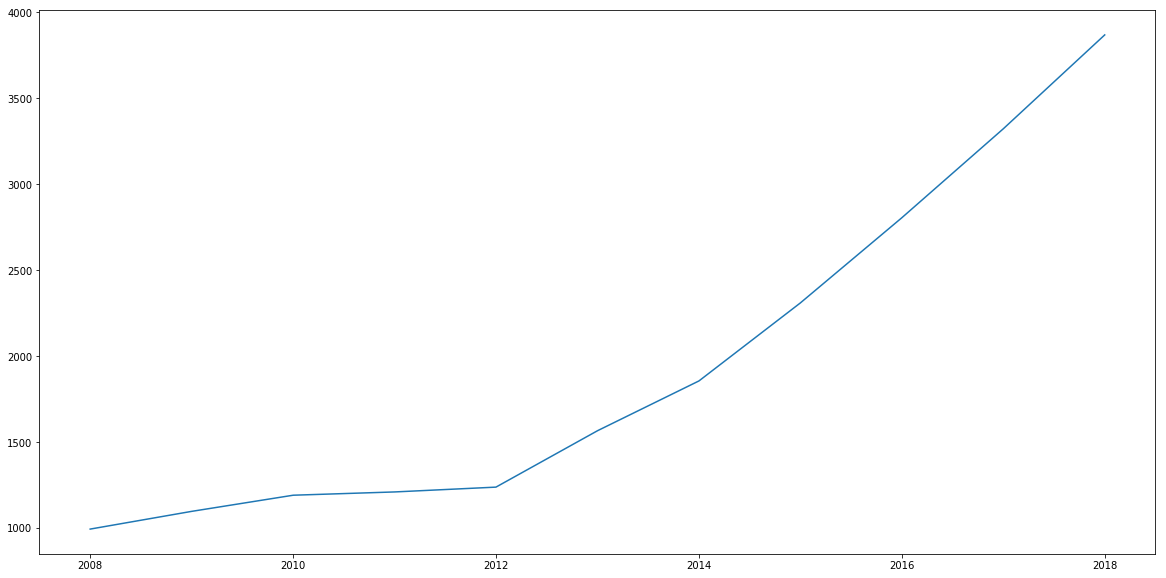

In [54]:
# Plot the data 
plt.plot(ts)

# 3. Checking Stationary

According to ARIMA the Chart should be stationaty to use the method 

According to the model, the set is stationary, when Test Statistic < Critical Value.
We use 3 rolling to check it. It's good to use rolling with a higher period, but we do not have enough data for it.

Use Dickey-Fuller test to check stationary

In [55]:
# Function for Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

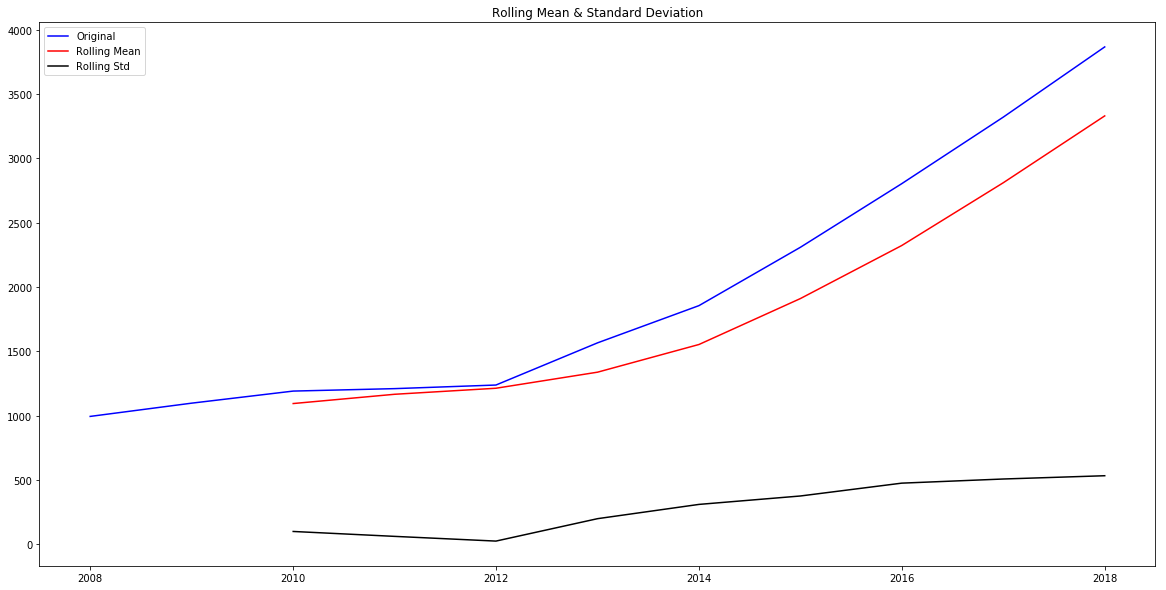

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     6.000000
Number of Observations Used    4.000000
Critical Value (1%)           -7.355441
Critical Value (5%)           -4.474365
Critical Value (10%)          -3.126933
dtype: float64


In [56]:
test_stationarity(ts)

Though the variation in standard deviation is small, the mean is clearly increasing with time and Test Static > Critical Value (10% ). This is not a stationary series. 

# 4. Make Time Series Stationary 

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. 
2. Seasonality – variations at specific time-frames. 

We do not have seasonality oin our data. We have only trend

### 4.1. Estimating & Eliminating Trend

##### Moving averages

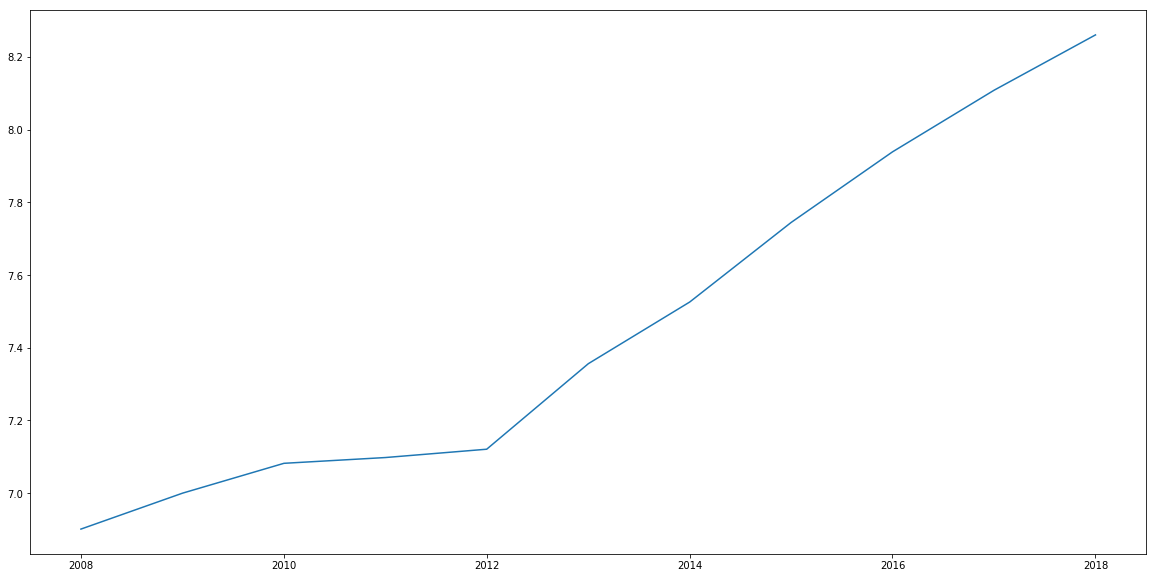

In [57]:
# Use Log transformation here
ts_log = np.log(ts)
plt.plot(ts_log)

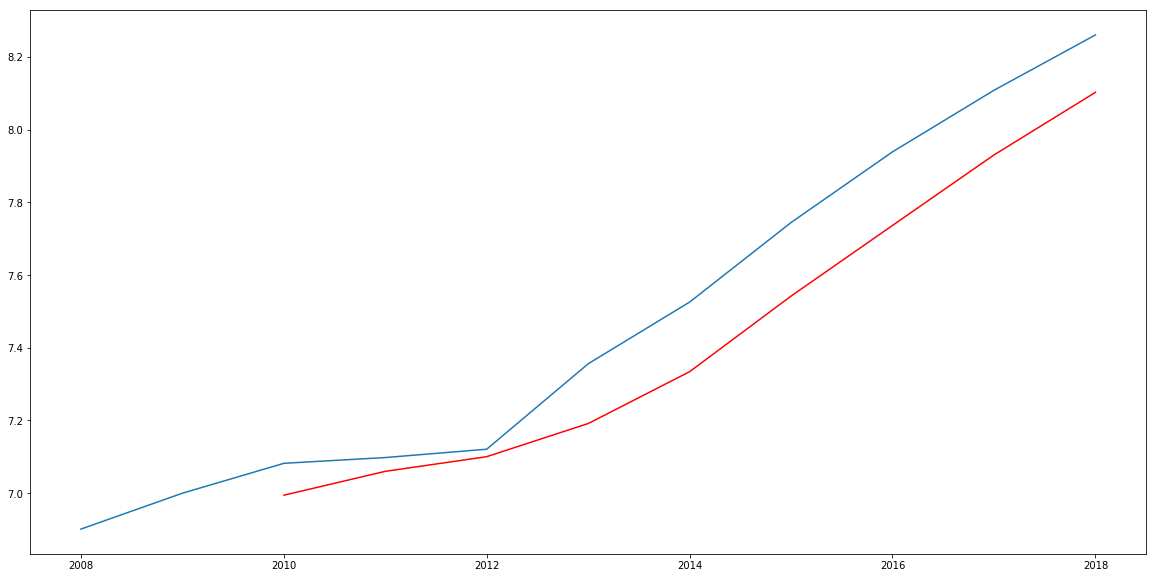

In [58]:
# Use smoothing (Moving Avarage with the period 3)
moving_avg = ts_log.rolling(3).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [59]:
# Get the difference between moving average and lo values
ts_log_moving_avg_diff = ts_log - moving_avg

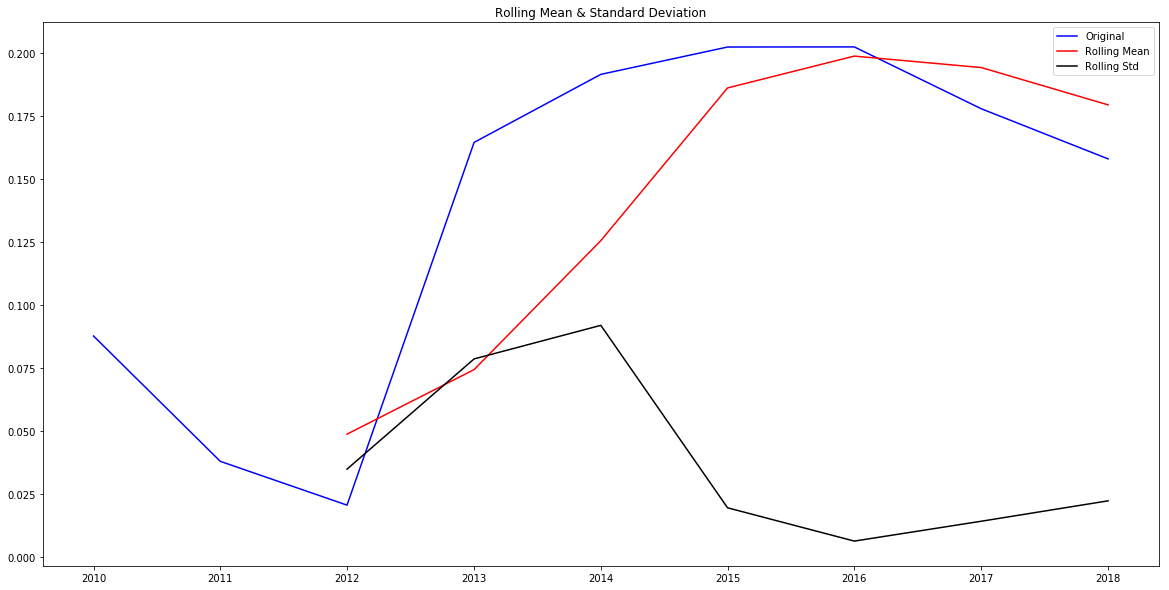

Results of Dickey-Fuller Test:
Test Statistic                -1.176385
p-value                        0.683671
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [60]:
# Display data on the chart and define stationary
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

It looks better, but the Time Series is not stationary. We see the trend in Original and rolling mean values and Test Static > Critical Value

Take a ‘weighted moving average’ where more recent values are given a higher weight. Use exponentially weighted moving average

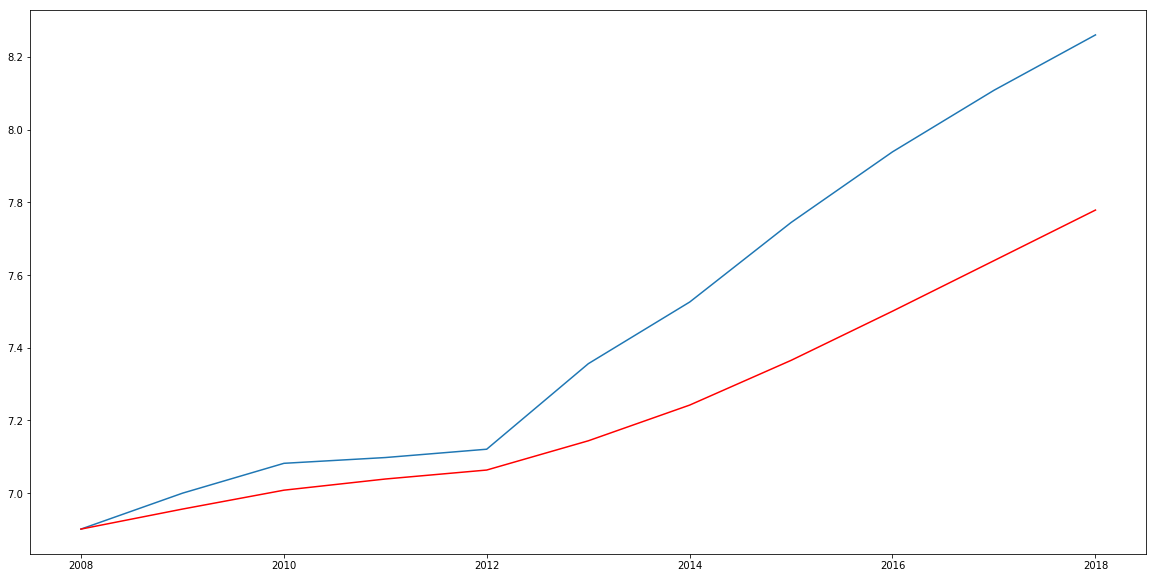

In [61]:
expwighted_avg = ts_log.ewm(halflife=3).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

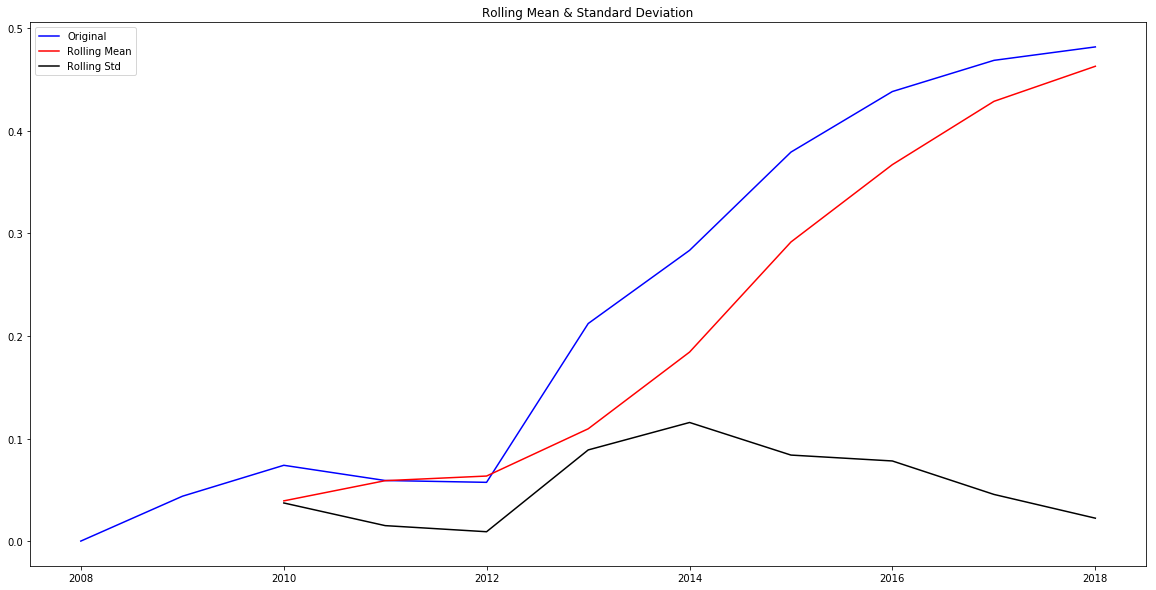

Results of Dickey-Fuller Test:
Test Statistic                 -0.000000
p-value                         0.958532
#Lags Used                      7.000000
Number of Observations Used     3.000000
Critical Value (1%)           -10.417191
Critical Value (5%)            -5.778381
Critical Value (10%)           -3.391681
dtype: float64


In [62]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Results become even worse. We see trends and big difference between Test Static and Critical Values

##### Differencing

Try to use Differencing

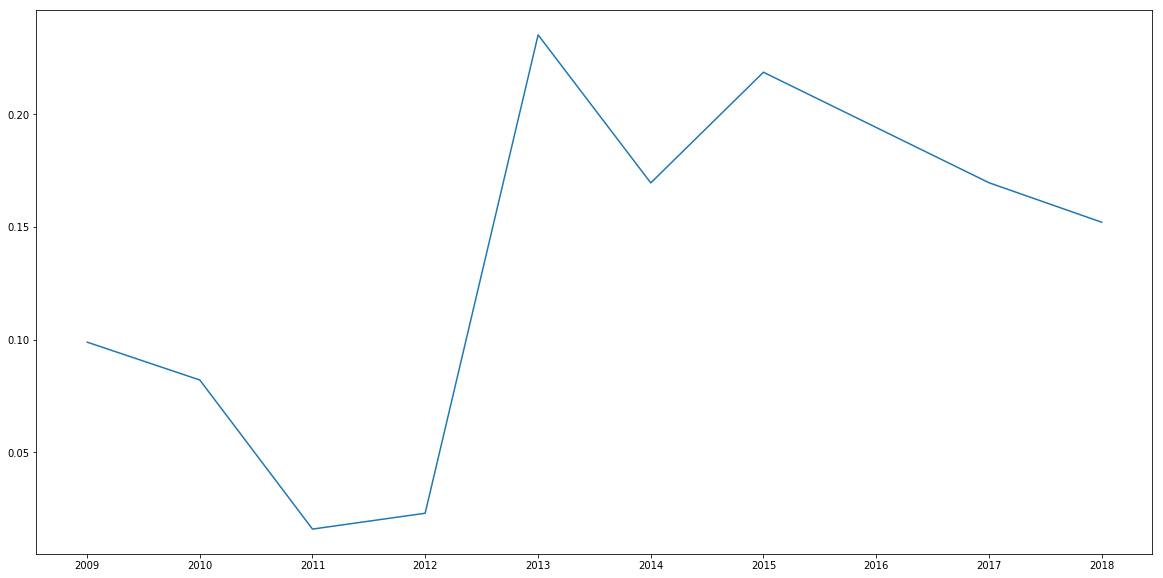

In [63]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

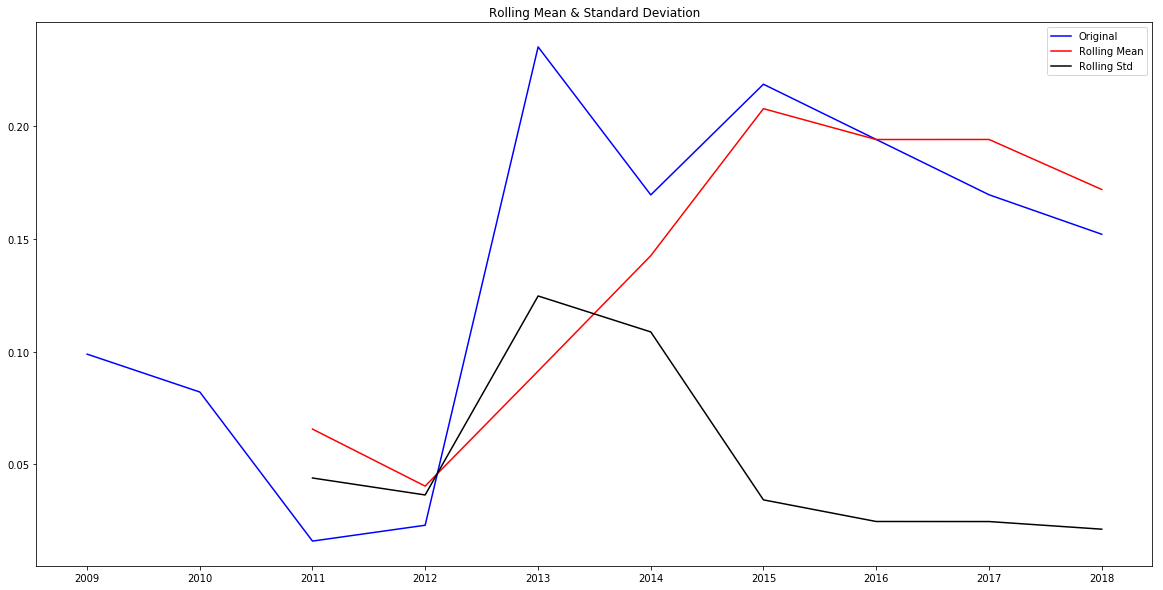

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     4.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


In [64]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Conclusion

All tests tell that Dataset is not stationary. We have only 11 objects for testing. 
ARIMA can not be used as a model for time series prediction using this dataset